In [1]:
#first import dependencies, mainly numpyro
import argparse
import os
import time
from jax.config import config
config.update("jax_enable_x64", True)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

#matplotlib.use("Agg")  # noqa: E402

In [2]:
# create artificial regression dataset
def get_data():
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
    #HI signal
    cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((64*64,150))/10000
    cosmos=cosmos.reshape((64*64,150))/10000
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1],dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1],dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [50]:
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-14,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = 10*var * jnp.exp(-0.5 * deltaXsq)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
    return k


def model(X, Y):
    # set weakly informative priors on our three kernel hyperparameters
    var_mean = numpyro.sample("var_mean", dist.HalfNormal(1))
    var_std = numpyro.sample("var_std", dist.HalfNormal(1))

    
    length_mean = numpyro.sample("length_mean", dist.InverseGamma(10,2))
    length_std = numpyro.sample("length_std", dist.HalfNormal(1))
    
    noise_mean = numpyro.sample("noise_mean", dist.HalfNormal(1))
    noise_std = numpyro.sample("noise_std", dist.HalfNormal(1))
    
    #sample for the var and length
    var_ksi = numpyro.sample("kernel_var",dist.Normal(loc=jnp.zeros(Y.shape[0])))
    length_ksi = numpyro.sample("kernel_length",dist.Normal(loc=jnp.zeros(Y.shape[0])))
    noise_ksi = numpyro.sample("kernel_noise",dist.Normal(loc=jnp.zeros(Y.shape[0])))
    
    var = var_std*var_ksi+var_mean
    length = length_std*length_ksi+length_mean
    noise = noise_std*noise_ksi+noise_mean
    
    X=jnp.repeat(jnp.array([X]),Y.shape[0],axis=0)
    # compute kernel
    vmap_args = (
        X,X,var,length,noise
    )
    
    k = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise
        )
    )(*vmap_args)
    #print(k.shape)
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((Y.shape[0],Y.shape[1])), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": 1.0, "kernel_noise": 0.05, "kernel_length": 0.5}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)
    kernel = NUTS(model, init_strategy=init_strategy,target_accept_prob=0.7,max_tree_depth=7)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=100,
        num_chains=1,
        thinning=1,
        progress_bar= True,
    )
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
@jax.jit
def predict(rng_key, X, Y, X_test, var, length, noise):
    X=jnp.repeat(jnp.array([X]),Y.shape[0],axis=0)
    # compute kernel of size (4096*150)
    vmap_args = (
        X,X,var,length,noise
    )
    
    k_pp = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=False
        )
    )(*vmap_args)
    k_pX = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=False
        )
    )(*vmap_args)
    k_XX = vmap(
        lambda X, Z, var, length, noise: kernel(
            X, Z,var, length, noise,is_noise=True
        )
    )(*vmap_args)
    
    #compute some useful matrix
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jax.lax.batch_matmul(k_pX, jax.lax.batch_matmul(K_xx_inv, jnp.transpose(k_pX,axes=(0,2,1))))
    
    vmap_args = (
        K_xx_inv,Y
    )
    cache = vmap(lambda A,B: jnp.matmul(A,B))(*vmap_args)
    vmap_args = (
        k_pX,cache
    )
    mean = vmap(lambda A,B: jnp.matmul(A,B))(*vmap_args)
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean




def main():
    X, Y, X_test = get_data()

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples = run_inference(model, "median", rng_key, X, Y)
    return samples

def make_predictions(samples):
    X, Y, X_test = get_data()
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    # do prediction
    kernel_var = samples["kernel_var"].T*samples["var_std"]+samples["var_mean"]
    kernel_noise = samples["kernel_noise"].T*samples["noise_std"]+samples["noise_mean"]
    kernel_length = samples["kernel_length"].T*samples["length_std"]+samples["length_mean"]
    #print(kernel_var.shape)
    #vmap_args = (
    #    random.split(rng_key_predict, samples["var_std"].shape[0]),
    #    kernel_var.T,
    #    kernel_length.T,
    #    kernel_noise.T,
    #)
    #means, predictions = vmap(
    #    lambda rng_key, var, length, noise: predict(
    #       rng_key, X, Y, X_test, var, length, noise
    #    )
    #)(*vmap_args)
    means = []
    for i in range(samples["var_std"].shape[0]):
        means.append(predict(
           rng_key, X, Y, X_test, kernel_var.T[i], kernel_noise.T[i], kernel_noise.T[i]
        ))
    #print(means）
    mean_prediction = np.mean(means, axis=0)
    percentiles = np.percentile(means, [5.0, 95.0], axis=0)
    
    return mean_prediction,percentiles

In [51]:
numpyro.set_platform('gpu')
numpyro.set_host_device_count(1)
samples = main()
jnp.save('samples.npy',samples)
#mean_prediction,percentiles = make_predictions(samples)

warmup:   4%| | 46/1100 [07:10<2:44:16,  9.35s/it, 127 steps of size 6.48e-04. a


KeyboardInterrupt: 

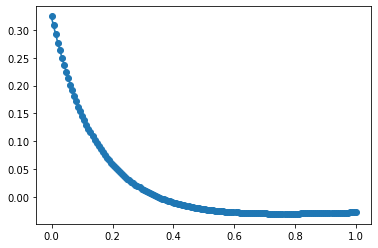

In [46]:
plt.fill_between(X_test, percentiles[0, 0,:], percentiles[1, 0,:], color="lightblue")
plt.scatter(X,Y[0])
plt.plot(X_test,mean_prediction[0])


In [47]:
sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy')

In [48]:
cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:64,192:256].transpose(2,1,0)
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(64*64,150)

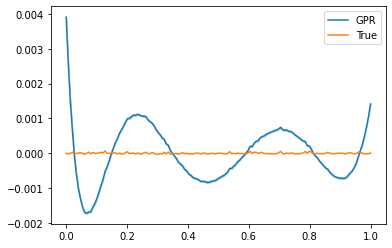

In [49]:
i=1200
plt.plot(X,Y[i]-mean_prediction[i])

plt.plot(X,cosmos[i]/10000)
plt.fill_between(X_test,Y[i]-percentiles[0, i,:], Y[i]-percentiles[1, i,:], color="lightblue")
plt.legend(['GPR','True'])

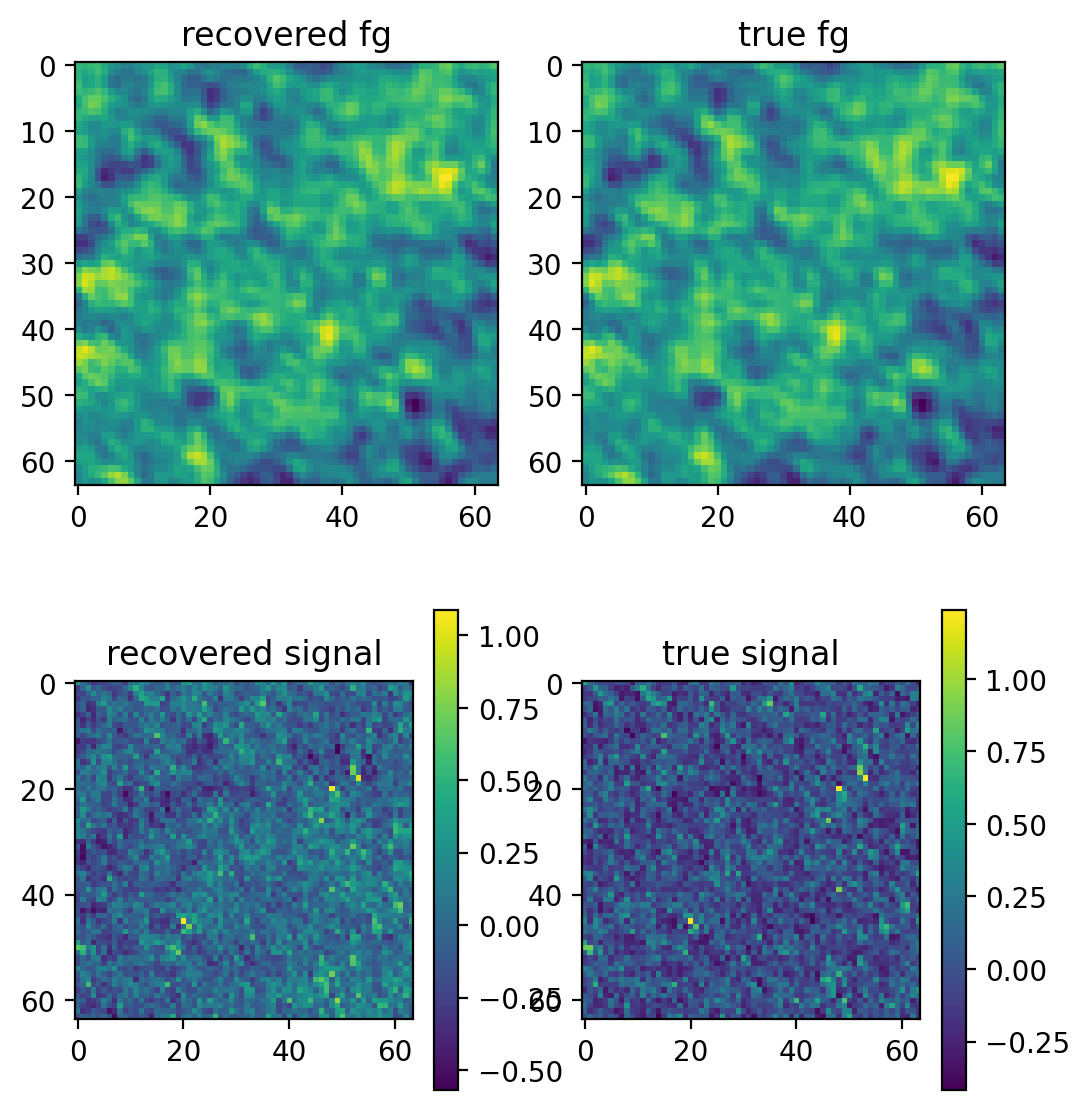

In [8]:
i=5
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(64,64))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(64,64))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_prediction[:,i]).reshape(64,64)*10000)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(64,64))
plt.title('true signal')
plt.colorbar()

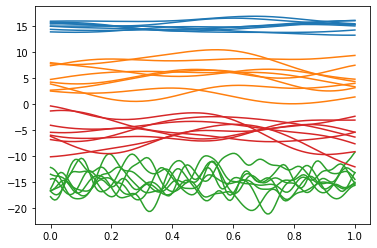

In [21]:
k1 = kernel(X, X,  0.052016747, 0.23297304, 1.81647456)
k2 = kernel(X, X,  1.52016747, 0.23297304, 1.81647456)
k3 = kernel(X, X,  0.52016747, 0.23297304, 1.81647456)
k4 = kernel(X, X,  0.52016747, 0.03297304, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=jnp.array([[k1,k2],[k3,k4]])),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i][0][0]+15,c='tab:blue')
    plt.plot(X,samp[i][1][0]+5,c='tab:orange')
    plt.plot(X,samp[i][0][1]-5,c='tab:red')
    plt.plot(X,samp[i][1][1]-15,c='tab:green')

In [160]:
numpyro.sample("kernel_var", dist.InverseGamma(10,2),rng_key= rng_key,sample_shape=(16,))

DeviceArray([0.16593575, 0.35661613, 0.44178466, 0.23166905, 0.19851243,
             0.26369422, 0.13496179, 0.21433583, 0.18115296, 0.14783476,
             0.28515543, 0.13975012, 0.13496239, 0.17410843, 0.21726044,
             0.12075873], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [7]:
samples['kernel_var']

DeviceArray([[ 1.06494367,  0.18133455, -0.03401261, ...,  0.04934063,
               0.10837382, -0.02980707],
             [ 1.06312066,  0.18602579, -0.03541603, ...,  0.05298757,
               0.10724168, -0.0293523 ],
             [ 1.06241003,  0.18561767, -0.03429944, ...,  0.05261361,
               0.1070131 , -0.02941075],
             ...,
             [ 1.06385229,  0.1849227 , -0.03340407, ...,  0.05780947,
               0.10791954, -0.03078482],
             [ 1.06385229,  0.1849227 , -0.03340407, ...,  0.05780947,
               0.10791954, -0.03078482],
             [ 1.06385229,  0.1849227 , -0.03340407, ...,  0.05780947,
               0.10791954, -0.03078482]], dtype=float64)

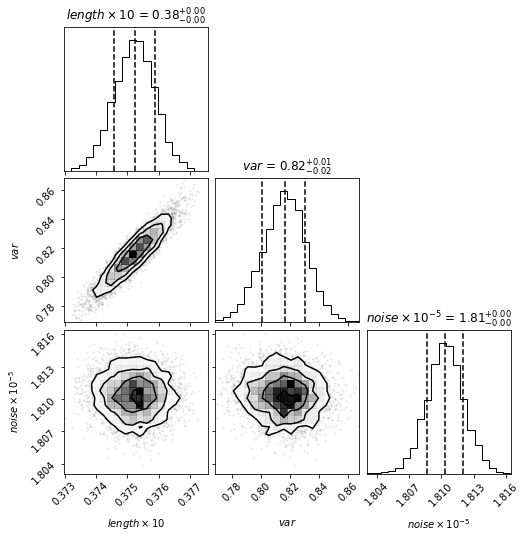

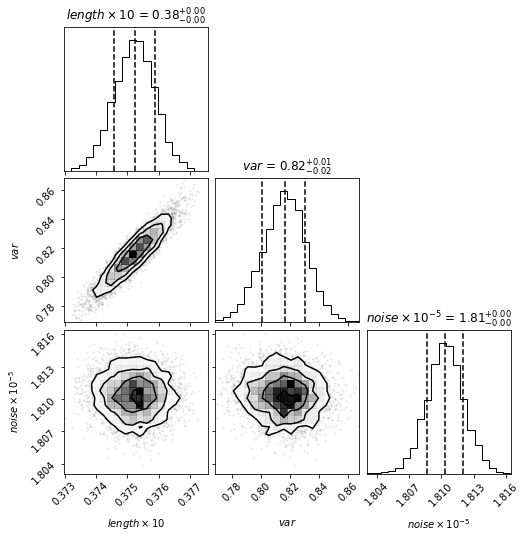

In [16]:
import corner
data = np.vstack([samples['kernel_length'],samples['kernel_var'],samples['kernel_noise']]).T
corner.corner(data,labels=[
        r"$length\times 10$",
        r"$var$",
        r"$noise\times 10^{-5}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [22]:
numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(64), covariance_matrix=k),
        obs=Y,
    )

(8, 2, 2, 150)

In [38]:
X,Y,X_test = get_data()

In [9]:
jnp.repeat(jnp.array([X]),150,axis=0)

DeviceArray([[0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ],
             [0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ],
             [0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ],
             ...,
             [0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ],
             [0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ],
             [0.        , 0.00671141, 0.01342282, ..., 0.98657718,
              0.99328859, 1.        ]], dtype=float64)

In [11]:
kernel_var = samples["kernel_var"].T*samples["var_std"]+samples["var_mean"]
kernel_var.shape

(4096, 100)

In [41]:
mean_prediction.shape

(2, 4096, 150)